Loading Train data from C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/degradation_data...
Loading Test data from C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/pseudo_testing_data_with_truth/...
Train Shape: (1805, 4)
Test Shape: (861, 4)
Generating Rolling Features...
Training Gaussian Mixture Model (GMM)...

 Training XGBoost Models...

FINAL RESULTS COMPARISON
Model 1 (Basic Features): RMSE = 5.4880 | R2 = 0.7547
Model 2 (With GMM Feats): RMSE = 5.3290   | R2 = 0.7687

Improvement with GMM: 2.90%


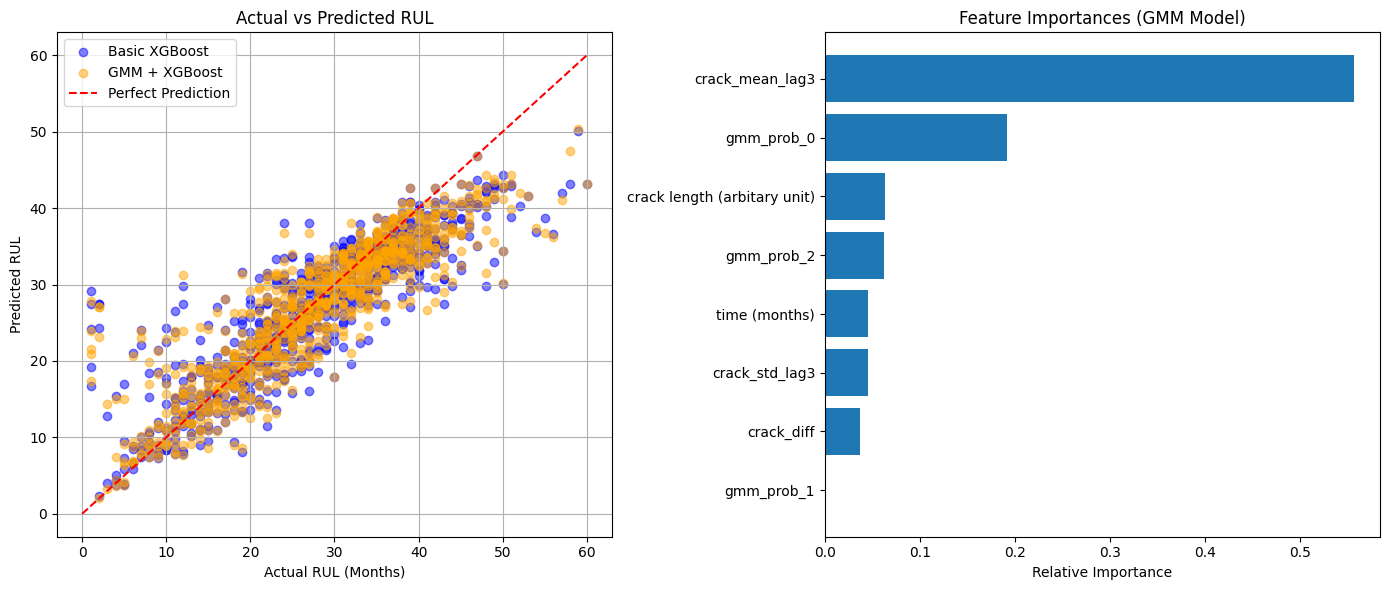


 GMM Cluster Analysis:
Means of the 3 clusters (Crack Length): [0.05103118 0.75518194 0.36551291]


In [10]:
import pandas as pd
import numpy as np
import glob
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
TRAIN_PATH = "C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/degradation_data"
TEST_PATH = "C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/pseudo_testing_data_with_truth/"

# ==========================================
# 2. DATA LOADING FUNCTION
# ==========================================
def load_data(folder_path, dataset_type="train"):
    all_files = glob.glob(os.path.join(folder_path, "item_*.csv"))
    df_list = []
    
    print(f"Loading {dataset_type} data from {folder_path}...")
    
    for filename in all_files:
        try:
            df = pd.read_csv(filename)
            # Extract Item ID from filename (e.g., item_0.csv -> 0)
            basename = os.path.basename(filename)
            item_id = int(re.findall(r'\d+', basename)[0])
            df['item_id'] = item_id
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {filename}: {e}")

    if not df_list:
        raise ValueError(f"No CSV files found in {folder_path}. Check your path!")

    full_df = pd.concat(df_list, axis=0, ignore_index=True)
    
    # Sort by item and time to ensure rolling features work correctly
    full_df = full_df.sort_values(by=['item_id', 'time (months)'])
    return full_df

# Load datasets
train_df = load_data(TRAIN_PATH, "Train")
test_df = load_data(TEST_PATH, "Test")

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")

# ==========================================
# 3. FEATURE ENGINEERING (Rolling Stats)
# ==========================================
def create_rolling_features(df):
    # group by item_id so rolling windows don't spill over from machine 0 to machine 1
    # calculate stats on 'crack length'
    
    # Window size 3: Looks at current month and previous 2 months
    df['crack_mean_lag3'] = df.groupby('item_id')['crack length (arbitary unit)'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    df['crack_std_lag3'] = df.groupby('item_id')['crack length (arbitary unit)'].transform(lambda x: x.rolling(window=3, min_periods=1).std())
    
    # Differential: How much did crack grow since last month?
    df['crack_diff'] = df.groupby('item_id')['crack length (arbitary unit)'].transform(lambda x: x.diff().fillna(0))
    
    # Fill NaN values created by rolling/std (first few rows) with 0
    df = df.fillna(0)
    return df

print("Generating Rolling Features...")
train_df = create_rolling_features(train_df)
test_df = create_rolling_features(test_df)

# ==========================================
# 4. GMM FEATURE EXTRACTION 
# ==========================================
print("Training Gaussian Mixture Model (GMM)...")

# only train GMM on the TRAINING data to avoid data leakage
# use 'crack length' to find clusters (Healthy vs Broken)
gmm_data = train_df[['crack length (arbitary unit)']].values

# n_components=3 implies: Healthy, Warning, Critical stages
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(gmm_data)

def add_gmm_features(df, gmm_model):
    data = df[['crack length (arbitary unit)']].values
    # Get probability of belonging to each cluster
    probs = gmm_model.predict_proba(data)
    
    # Add these probabilities as new columns
    df['gmm_prob_0'] = probs[:, 0]
    df['gmm_prob_1'] = probs[:, 1]
    df['gmm_prob_2'] = probs[:, 2]
    return df

train_df = add_gmm_features(train_df, gmm)
test_df = add_gmm_features(test_df, gmm)

# ==========================================
# 5. PREPARE FOR XGBOOST
# ==========================================
target_col = 'rul (months)'
drop_cols = ['item_id', 'rul (months)']

# Define Feature Sets
basic_features = ['time (months)', 'crack length (arbitary unit)', 'crack_mean_lag3', 'crack_std_lag3', 'crack_diff']
gmm_features = basic_features + ['gmm_prob_0', 'gmm_prob_1', 'gmm_prob_2']

X_train_basic = train_df[basic_features]
X_train_gmm = train_df[gmm_features]
y_train = train_df[target_col]

X_test_basic = test_df[basic_features]
X_test_gmm = test_df[gmm_features]
y_test = test_df[target_col]

# ==========================================
# 6. MODEL TRAINING & COMPARISON
# ==========================================
print("\n Training XGBoost Models...")

# Model 1: Without GMM
model_basic = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model_basic.fit(X_train_basic, y_train)
preds_basic = model_basic.predict(X_test_basic)

# Model 2: With GMM
model_gmm = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model_gmm.fit(X_train_gmm, y_train)
preds_gmm = model_gmm.predict(X_test_gmm)

# ==========================================
# 7. EVALUATION METRICS
# ==========================================
rmse_basic = np.sqrt(mean_squared_error(y_test, preds_basic))
rmse_gmm = np.sqrt(mean_squared_error(y_test, preds_gmm))
r2_basic = r2_score(y_test, preds_basic)
r2_gmm = r2_score(y_test, preds_gmm)

print("\n" + "="*40)
print("FINAL RESULTS COMPARISON")
print("="*40)
print(f"Model 1 (Basic Features): RMSE = {rmse_basic:.4f} | R2 = {r2_basic:.4f}")
print(f"Model 2 (With GMM Feats): RMSE = {rmse_gmm:.4f}   | R2 = {r2_gmm:.4f}")

improvement = ((rmse_basic - rmse_gmm) / rmse_basic) * 100
print(f"\nImprovement with GMM: {improvement:.2f}%")

# ==========================================
# 8. VISUALIZATION
# ==========================================
plt.figure(figsize=(14, 6))

# Plot 1: Actual vs Predicted (Scatter)
plt.subplot(1, 2, 1)
plt.scatter(y_test, preds_basic, alpha=0.5, label='Basic XGBoost', color='blue')
plt.scatter(y_test, preds_gmm, alpha=0.5, label='GMM + XGBoost', color='orange')
plt.plot([0, 60], [0, 60], 'r--', label='Perfect Prediction')
plt.xlabel('Actual RUL (Months)')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.grid(True)

# Plot 2: Feature Importance (GMM Model)
plt.subplot(1, 2, 2)
importances = model_gmm.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances (GMM Model)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [gmm_features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.tight_layout()
plt.show()

# ==========================================
# 9. ANALYZE GMM CLUSTERS
# ==========================================
print("\n GMM Cluster Analysis:")
print(f"Means of the 3 clusters (Crack Length): {gmm.means_.flatten()}")
# This tells which cluster corresponds to "Healthy" (Lowest mean) 
# and which is "Critical" (Highest mean)

Loading Train data from C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/degradation_data...
Loading Test data from C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/pseudo_testing_data_with_truth/...
Train Shape: (1805, 4)
Test Shape: (861, 4)
Generating Rolling Features...
Training Gaussian Mixture Model (GMM)...

 Starting Grid Search for Best Hyperparameters...

 Tuning Basic Model (No GMM)...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
 Best Basic Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
   Best CV Score (RMSE): 7.8046

 Tuning GMM Model...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
 Best GMM Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
   Best CV Score (RMSE): 7.8067

 Generating Predictions with Op

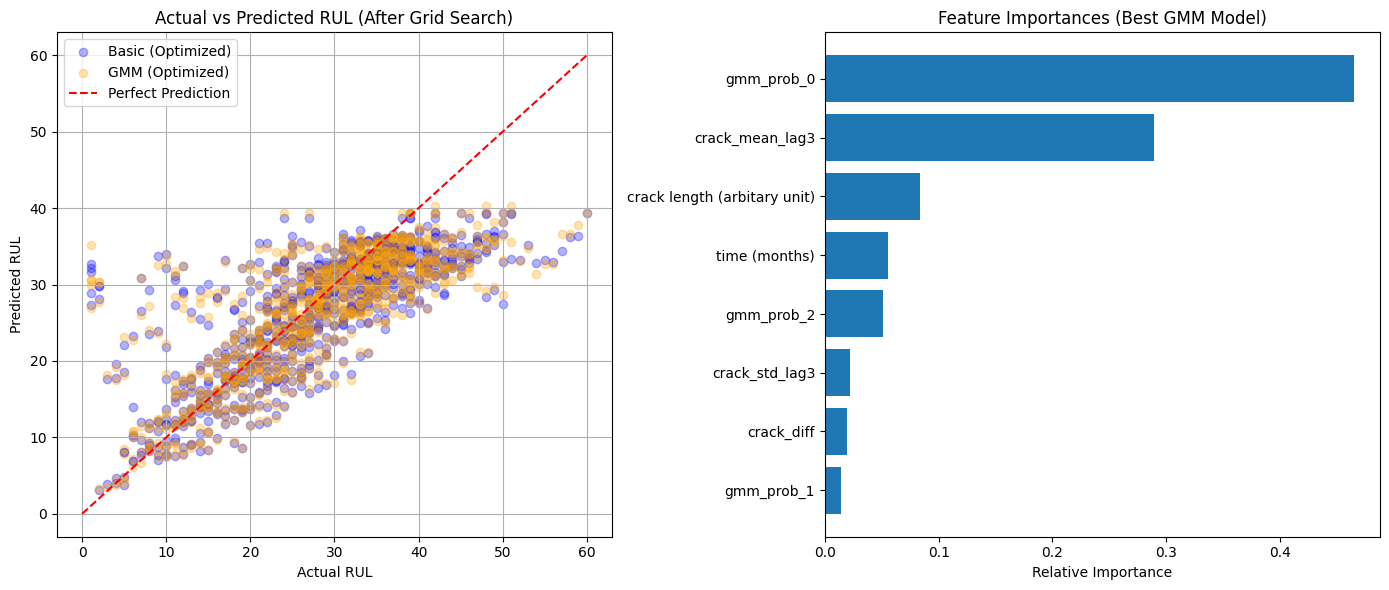

In [11]:
import pandas as pd
import numpy as np
import glob
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
TRAIN_PATH = "C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/degradation_data"
TEST_PATH = "C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/pseudo_testing_data_with_truth/"

# ==========================================
# 2. DATA LOADING FUNCTION
# ==========================================
def load_data(folder_path, dataset_type="train"):
    all_files = glob.glob(os.path.join(folder_path, "item_*.csv"))
    df_list = []
    
    print(f"Loading {dataset_type} data from {folder_path}...")
    
    for filename in all_files:
        try:
            df = pd.read_csv(filename)
            # Extract Item ID from filename (e.g., item_0.csv -> 0)
            basename = os.path.basename(filename)
            item_id = int(re.findall(r'\d+', basename)[0])
            df['item_id'] = item_id
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {filename}: {e}")

    if not df_list:
        raise ValueError(f"No CSV files found in {folder_path}. Check your path!")

    full_df = pd.concat(df_list, axis=0, ignore_index=True)
    
    # Sort by item and time to ensure rolling features work correctly
    full_df = full_df.sort_values(by=['item_id', 'time (months)'])
    return full_df

# Load datasets
train_df = load_data(TRAIN_PATH, "Train")
test_df = load_data(TEST_PATH, "Test")

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")

# ==========================================
# 3. FEATURE ENGINEERING (Rolling Stats)
# ==========================================
def create_rolling_features(df):
    # group by item_id so rolling windows don't spill over from machine 0 to machine 1
    # calculate stats on 'crack length'
    
    # Window size 3: Looks at current month and previous 2 months
    df['crack_mean_lag3'] = df.groupby('item_id')['crack length (arbitary unit)'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    df['crack_std_lag3'] = df.groupby('item_id')['crack length (arbitary unit)'].transform(lambda x: x.rolling(window=3, min_periods=1).std())
    
    # Differential: How much did crack grow since last month?
    df['crack_diff'] = df.groupby('item_id')['crack length (arbitary unit)'].transform(lambda x: x.diff().fillna(0))
    
    # Fill NaN values created by rolling/std (first few rows) with 0
    df = df.fillna(0)
    return df

print("Generating Rolling Features...")
train_df = create_rolling_features(train_df)
test_df = create_rolling_features(test_df)

# ==========================================
# 4. GMM FEATURE EXTRACTION 
# ==========================================
print("Training Gaussian Mixture Model (GMM)...")

# only train GMM on the TRAINING data to avoid data leakage
# use 'crack length' to find clusters (Healthy vs Broken)
gmm_data = train_df[['crack length (arbitary unit)']].values

# n_components=3 implies: Healthy, Warning, Critical stages
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(gmm_data)

def add_gmm_features(df, gmm_model):
    data = df[['crack length (arbitary unit)']].values
    # Get probability of belonging to each cluster
    probs = gmm_model.predict_proba(data)
    
    # Add these probabilities as new columns
    df['gmm_prob_0'] = probs[:, 0]
    df['gmm_prob_1'] = probs[:, 1]
    df['gmm_prob_2'] = probs[:, 2]
    return df

train_df = add_gmm_features(train_df, gmm)
test_df = add_gmm_features(test_df, gmm)

# ==========================================
# 5. PREPARE FOR XGBOOST
# ==========================================
target_col = 'rul (months)'
drop_cols = ['item_id', 'rul (months)']

# Define Feature Sets
basic_features = ['time (months)', 'crack length (arbitary unit)', 'crack_mean_lag3', 'crack_std_lag3', 'crack_diff']
gmm_features = basic_features + ['gmm_prob_0', 'gmm_prob_1', 'gmm_prob_2']

X_train_basic = train_df[basic_features]
X_train_gmm = train_df[gmm_features]
y_train = train_df[target_col]

X_test_basic = test_df[basic_features]
X_test_gmm = test_df[gmm_features]
y_test = test_df[target_col]

from sklearn.model_selection import GridSearchCV

# ==========================================
# 6. HYPERPARAMETER TUNING (GRID SEARCH)
# ==========================================
print("\n Starting Grid Search for Best Hyperparameters...")

# A. Define the Parameter Grid
# These are the "knobs" we want to turn to see what works best
param_grid = {
    'n_estimators': [50, 100, 200],       # How many trees?
    'learning_rate': [0.01, 0.1, 0.2],    # How fast to learn?
    'max_depth': [3, 5, 7],               # How complex can each tree be?
    'subsample': [0.8],                   # Use 80% of data to prevent overfitting
    'colsample_bytree': [0.8]             # Use 80% of features per tree
}

# Initialize the base model
xgb_base = XGBRegressor(random_state=42, n_jobs=-1) # n_jobs=-1 uses all CPU cores

# --- Tuning Model 1: Basic Features ---
print("\n Tuning Basic Model (No GMM)...")
grid_basic = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=3,                           # 3-Fold Cross Validation
    scoring='neg_root_mean_squared_error', # Optimize for lowest RMSE
    verbose=1
)
grid_basic.fit(X_train_basic, y_train)

best_model_basic = grid_basic.best_estimator_
print(f" Best Basic Params: {grid_basic.best_params_}")
print(f"   Best CV Score (RMSE): {-grid_basic.best_score_:.4f}")

# --- Tuning Model 2: With GMM Features ---
print("\n Tuning GMM Model...")
grid_gmm = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1
)
grid_gmm.fit(X_train_gmm, y_train)

best_model_gmm = grid_gmm.best_estimator_
print(f" Best GMM Params: {grid_gmm.best_params_}")
print(f"   Best CV Score (RMSE): {-grid_gmm.best_score_:.4f}")

# ==========================================
# 7. FINAL PREDICTION & EVALUATION
# ==========================================
print("\n Generating Predictions with Optimized Models...")

# Predict on Test Set
preds_basic = best_model_basic.predict(X_test_basic)
preds_gmm = best_model_gmm.predict(X_test_gmm)

# Calculate Metrics
rmse_basic = np.sqrt(mean_squared_error(y_test, preds_basic))
rmse_gmm = np.sqrt(mean_squared_error(y_test, preds_gmm))
r2_basic = r2_score(y_test, preds_basic)
r2_gmm = r2_score(y_test, preds_gmm)

print("\n" + "="*40)
print(" FINAL RESULTS COMPARISON (OPTIMIZED)")
print("="*40)
print(f"Model 1 (Basic): RMSE = {rmse_basic:.4f} | R2 = {r2_basic:.4f}")
print(f"Model 2 (w/GMM): RMSE = {rmse_gmm:.4f}   | R2 = {r2_gmm:.4f}")

improvement = ((rmse_basic - rmse_gmm) / rmse_basic) * 100
print(f"\n Improvement with GMM: {improvement:.2f}%")

# ==========================================
# 8. VISUALIZATION
# ==========================================
plt.figure(figsize=(14, 6))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, preds_basic, alpha=0.3, label='Basic (Optimized)', color='blue')
plt.scatter(y_test, preds_gmm, alpha=0.3, label='GMM (Optimized)', color='orange')
plt.plot([0, 60], [0, 60], 'r--', label='Perfect Prediction')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (After Grid Search)')
plt.legend()
plt.grid(True)

# Plot 2: Feature Importance
plt.subplot(1, 2, 2)
importances = best_model_gmm.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances (Best GMM Model)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [gmm_features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.tight_layout()
plt.show()

Loading Train data from C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/degradation_data...
Loading Test data from C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/pseudo_testing_data_with_truth/...
Train Shape: (1805, 4)
Test Shape: (861, 4)
Generating Rolling Features...
Training Gaussian Mixture Model (GMM)...

 Starting Group-Aware Grid Search...

 Tuning Basic Model...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
 Best Basic Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

 Tuning GMM Model...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
 Best GMM Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

 Generating Predictions...

 FINAL RESULTS (Fixed Cross-Validation)
Model 1 (Basic): RMSE = 7.4499 | R2 = 0.5480


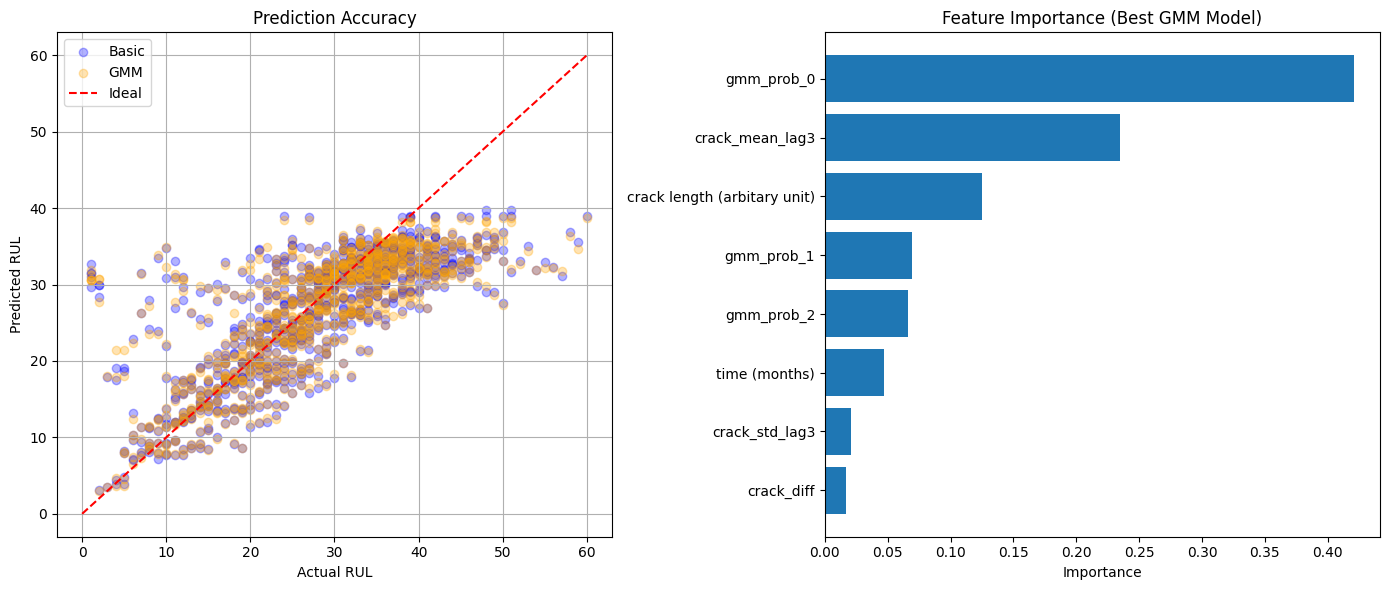

In [12]:
import pandas as pd
import numpy as np
import glob
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
TRAIN_PATH = "C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/degradation_data"
TEST_PATH = "C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/pseudo_testing_data_with_truth/"

# ==========================================
# 2. DATA LOADING FUNCTION
# ==========================================
def load_data(folder_path, dataset_type="train"):
    all_files = glob.glob(os.path.join(folder_path, "item_*.csv"))
    df_list = []
    
    print(f"Loading {dataset_type} data from {folder_path}...")
    
    for filename in all_files:
        try:
            df = pd.read_csv(filename)
            # Extract Item ID from filename (e.g., item_0.csv -> 0)
            basename = os.path.basename(filename)
            item_id = int(re.findall(r'\d+', basename)[0])
            df['item_id'] = item_id
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {filename}: {e}")

    if not df_list:
        raise ValueError(f"No CSV files found in {folder_path}. Check your path!")

    full_df = pd.concat(df_list, axis=0, ignore_index=True)
    
    # Sort by item and time to ensure rolling features work correctly
    full_df = full_df.sort_values(by=['item_id', 'time (months)'])
    return full_df

# Load datasets
train_df = load_data(TRAIN_PATH, "Train")
test_df = load_data(TEST_PATH, "Test")

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")

# ==========================================
# 3. FEATURE ENGINEERING
# ==========================================
def create_rolling_features(df):
    # group by item_id so rolling windows don't spill over from machine 0 to machine 1
    # calculate stats on 'crack length'
    
    # Window size 3: Looks at current month and previous 2 months
    df['crack_mean_lag3'] = df.groupby('item_id')['crack length (arbitary unit)'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    df['crack_std_lag3'] = df.groupby('item_id')['crack length (arbitary unit)'].transform(lambda x: x.rolling(window=3, min_periods=1).std())
    
    # Differential: How much did crack grow since last month?
    df['crack_diff'] = df.groupby('item_id')['crack length (arbitary unit)'].transform(lambda x: x.diff().fillna(0))
    
    # Fill NaN values created by rolling/std (first few rows) with 0
    df = df.fillna(0)
    return df

print("Generating Rolling Features...")
train_df = create_rolling_features(train_df)
test_df = create_rolling_features(test_df)

# ==========================================
# 4. GMM FEATURE EXTRACTION 
# ==========================================
print("Training Gaussian Mixture Model (GMM)...")

# only train GMM on the TRAINING data to avoid data leakage
# use 'crack length' to find clusters (Healthy vs Broken)
gmm_data = train_df[['crack length (arbitary unit)']].values

# n_components=3 implies: Healthy, Warning, Critical stages
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(gmm_data)

def add_gmm_features(df, gmm_model):
    data = df[['crack length (arbitary unit)']].values
    # Get probability of belonging to each cluster
    probs = gmm_model.predict_proba(data)
    
    # Add these probabilities as new columns
    df['gmm_prob_0'] = probs[:, 0]
    df['gmm_prob_1'] = probs[:, 1]
    df['gmm_prob_2'] = probs[:, 2]
    return df

train_df = add_gmm_features(train_df, gmm)
test_df = add_gmm_features(test_df, gmm)

# ==========================================
# 5. PREPARE FOR XGBOOST
# ==========================================
target_col = 'rul (months)'
drop_cols = ['item_id', 'rul (months)']

# Define Feature Sets
basic_features = ['time (months)', 'crack length (arbitary unit)', 'crack_mean_lag3', 'crack_std_lag3', 'crack_diff']
gmm_features = basic_features + ['gmm_prob_0', 'gmm_prob_1', 'gmm_prob_2']

X_train_basic = train_df[basic_features]
X_train_gmm = train_df[gmm_features]
y_train = train_df[target_col]

X_test_basic = test_df[basic_features]
X_test_gmm = test_df[gmm_features]
y_test = test_df[target_col]

from sklearn.model_selection import GridSearchCV, GroupKFold

# ==========================================
# 6. GROUP-AWARE GRID SEARCH
# ==========================================
print("\n Starting Group-Aware Grid Search...")

# Define Parameter Grid
# shifted range up because data good with complex models
param_grid = {
    'n_estimators': [100, 200, 300],      # Removed 50 (too simple)
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Define Group Splitter
# ensures we split by 'item_id' not by random rows
gkf = GroupKFold(n_splits=3)

# need the 'item_id' for the groups extracting it from train_df
groups = train_df['item_id'].values

xgb_base = XGBRegressor(random_state=42, n_jobs=-1)

# --- Tuning Model 1: Basic Features ---
print("\n Tuning Basic Model...")
grid_basic = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=gkf,  # <-------GroupKFold
    scoring='neg_root_mean_squared_error',
    verbose=1
)
# pass 'groups' to .fit()
grid_basic.fit(X_train_basic, y_train, groups=groups)

best_model_basic = grid_basic.best_estimator_
print(f" Best Basic Params: {grid_basic.best_params_}")

# --- Tuning Model 2: With GMM Features ---
print("\n Tuning GMM Model...")
grid_gmm = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=gkf,  
    scoring='neg_root_mean_squared_error',
    verbose=1
)
grid_gmm.fit(X_train_gmm, y_train, groups=groups)

best_model_gmm = grid_gmm.best_estimator_
print(f" Best GMM Params: {grid_gmm.best_params_}")

# ==========================================
# 7. FINAL EVALUATION
# ==========================================
print("\n Generating Predictions...")

preds_basic = best_model_basic.predict(X_test_basic)
preds_gmm = best_model_gmm.predict(X_test_gmm)

rmse_basic = np.sqrt(mean_squared_error(y_test, preds_basic))
rmse_gmm = np.sqrt(mean_squared_error(y_test, preds_gmm))
r2_basic = r2_score(y_test, preds_basic)
r2_gmm = r2_score(y_test, preds_gmm)

print("\n" + "="*40)
print(" FINAL RESULTS (Fixed Cross-Validation)")
print("="*40)
print(f"Model 1 (Basic): RMSE = {rmse_basic:.4f} | R2 = {r2_basic:.4f}")
print(f"Model 2 (w/GMM): RMSE = {rmse_gmm:.4f}   | R2 = {r2_gmm:.4f}")

improvement = ((rmse_basic - rmse_gmm) / rmse_basic) * 100
print(f"\n Improvement with GMM: {improvement:.2f}%")

# ==========================================
# 8. PLOT
# ==========================================
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, preds_basic, alpha=0.3, label='Basic', color='blue')
plt.scatter(y_test, preds_gmm, alpha=0.3, label='GMM', color='orange')
plt.plot([0, 60], [0, 60], 'r--', label='Ideal')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Prediction Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
importances = best_model_gmm.feature_importances_
indices = np.argsort(importances)
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [gmm_features[i] for i in indices])
plt.xlabel('Importance')
plt.title('Feature Importance (Best GMM Model)')
plt.tight_layout()
plt.show()

Loading Train data from C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/degradation_data...
Loading Test data from C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/pseudo_testing_data_with_truth/...
Train Shape: (1805, 4)
Test Shape: (861, 4)
Generating Rolling Features...
Training Gaussian Mixture Model (GMM)...

 Starting Targeted Grid Search (Round 2)...
Round 1 selected 'max_depth: 3' which caused underfitting.
Action: Forcing search space into higher complexity models.

 Tuning Basic Model...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
 Best Basic Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

 Tuning GMM Model...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
 Best GMM Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsamp

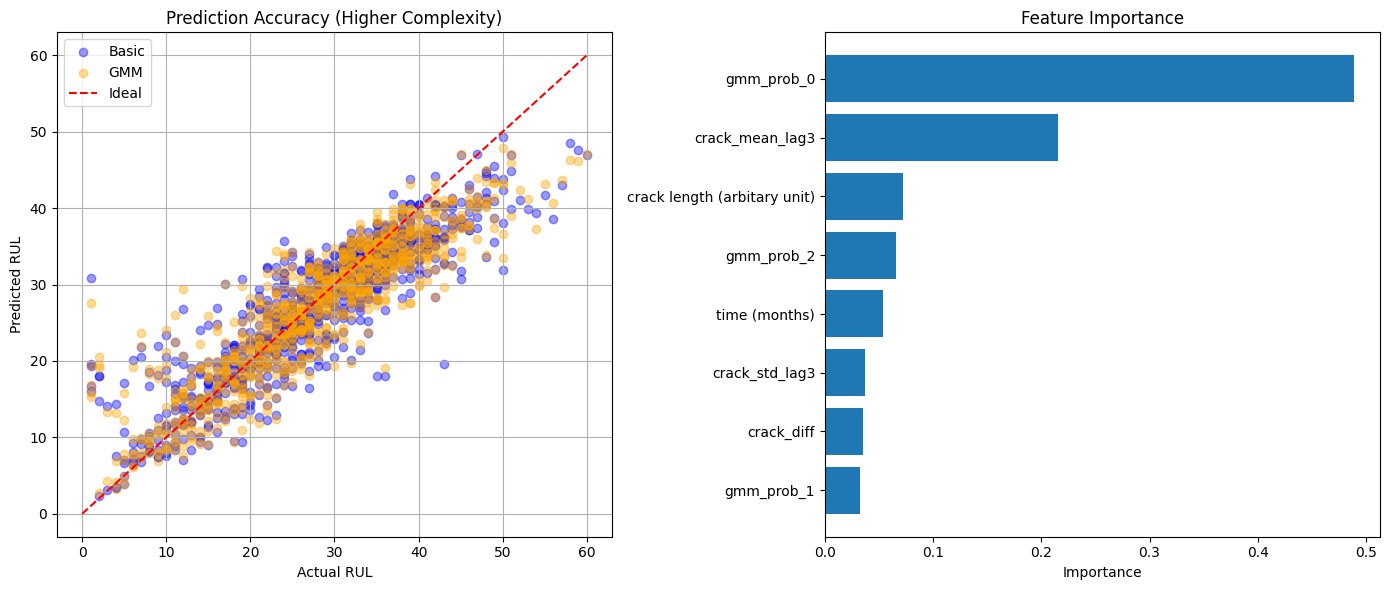

In [13]:
import pandas as pd
import numpy as np
import glob
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
TRAIN_PATH = "C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/degradation_data"
TEST_PATH = "C:/Users/nihar/Desktop/ASU_SEM_3/MLFPGA/project/robot_maintenance-main/robot_maintenance-main/training_data/pseudo_testing_data_with_truth/"

# ==========================================
# 2. DATA LOADING FUNCTION
# ==========================================
def load_data(folder_path, dataset_type="train"):
    all_files = glob.glob(os.path.join(folder_path, "item_*.csv"))
    df_list = []
    
    print(f"Loading {dataset_type} data from {folder_path}...")
    
    for filename in all_files:
        try:
            df = pd.read_csv(filename)
            # Extract Item ID from filename (e.g., item_0.csv -> 0)
            basename = os.path.basename(filename)
            item_id = int(re.findall(r'\d+', basename)[0])
            df['item_id'] = item_id
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {filename}: {e}")

    if not df_list:
        raise ValueError(f"No CSV files found in {folder_path}. Check your path!")

    full_df = pd.concat(df_list, axis=0, ignore_index=True)
    
    # Sort by item and time to ensure rolling features work correctly
    full_df = full_df.sort_values(by=['item_id', 'time (months)'])
    return full_df

# Load datasets
train_df = load_data(TRAIN_PATH, "Train")
test_df = load_data(TEST_PATH, "Test")

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")

# ==========================================
# 3. FEATURE ENGINEERING (Rolling Stats)
# ==========================================
def create_rolling_features(df):
    # group by item_id so rolling windows don't spill over from machine 0 to machine 1
    # calculate stats on 'crack length'
    
    # Window size 3: Looks at current month and previous 2 months
    df['crack_mean_lag3'] = df.groupby('item_id')['crack length (arbitary unit)'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    df['crack_std_lag3'] = df.groupby('item_id')['crack length (arbitary unit)'].transform(lambda x: x.rolling(window=3, min_periods=1).std())
    
    # Differential: How much did crack grow since last month?
    df['crack_diff'] = df.groupby('item_id')['crack length (arbitary unit)'].transform(lambda x: x.diff().fillna(0))
    
    # Fill NaN values created by rolling/std (first few rows) with 0
    df = df.fillna(0)
    return df

print("Generating Rolling Features...")
train_df = create_rolling_features(train_df)
test_df = create_rolling_features(test_df)

# ==========================================
# 4. GMM FEATURE EXTRACTION 
# ==========================================
print("Training Gaussian Mixture Model (GMM)...")

# only train GMM on the TRAINING data to avoid data leakage
# use 'crack length' to find clusters (Healthy vs Broken)
gmm_data = train_df[['crack length (arbitary unit)']].values

# n_components=3 implies: Healthy, Warning, Critical stages
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(gmm_data)

def add_gmm_features(df, gmm_model):
    data = df[['crack length (arbitary unit)']].values
    # Get probability of belonging to each cluster
    probs = gmm_model.predict_proba(data)
    
    # Add these probabilities as new columns
    df['gmm_prob_0'] = probs[:, 0]
    df['gmm_prob_1'] = probs[:, 1]
    df['gmm_prob_2'] = probs[:, 2]
    return df

train_df = add_gmm_features(train_df, gmm)
test_df = add_gmm_features(test_df, gmm)

# ==========================================
# 5. PREPARE FOR XGBOOST
# ==========================================
target_col = 'rul (months)'
drop_cols = ['item_id', 'rul (months)']

# Define Feature Sets
basic_features = ['time (months)', 'crack length (arbitary unit)', 'crack_mean_lag3', 'crack_std_lag3', 'crack_diff']
gmm_features = basic_features + ['gmm_prob_0', 'gmm_prob_1', 'gmm_prob_2']

X_train_basic = train_df[basic_features]
X_train_gmm = train_df[gmm_features]
y_train = train_df[target_col]

X_test_basic = test_df[basic_features]
X_test_gmm = test_df[gmm_features]
y_test = test_df[target_col]

# ==========================================
# 6. TARGETED GRID SEARCH (ITERATION 2)
# ==========================================
print("\n Starting Targeted Grid Search (Round 2)...")
print("Round 1 selected 'max_depth: 3' which caused underfitting.")
print("Action: Forcing search space into higher complexity models.")

#"Aggressive" Parameter Grid
# removed depth 3. Forcing it to look at 5, 6, and 7.
# removed learning_rate 0.05 to learn faster.
param_grid = {
    'n_estimators': [100, 150, 200],      
    'learning_rate': [0.1, 0.15, 0.2],   
    'max_depth': [5, 6, 7],               
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Define Group Splitter
gkf = GroupKFold(n_splits=3)
groups = train_df['item_id'].values
xgb_base = XGBRegressor(random_state=42, n_jobs=-1)

# --- Tuning Model 1: Basic Features ---
print("\n Tuning Basic Model...")
grid_basic = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=gkf,
    scoring='neg_root_mean_squared_error',
    verbose=1
)
grid_basic.fit(X_train_basic, y_train, groups=groups)
best_model_basic = grid_basic.best_estimator_
print(f" Best Basic Params: {grid_basic.best_params_}")

# --- Tuning Model 2: With GMM Features ---
print("\n Tuning GMM Model...")
grid_gmm = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=gkf,
    scoring='neg_root_mean_squared_error',
    verbose=1
)
grid_gmm.fit(X_train_gmm, y_train, groups=groups)
best_model_gmm = grid_gmm.best_estimator_
print(f" Best GMM Params: {grid_gmm.best_params_}")

# ==========================================
# 7. FINAL EVALUATION
# ==========================================
print("\n Generating Predictions...")

preds_basic = best_model_basic.predict(X_test_basic)
preds_gmm = best_model_gmm.predict(X_test_gmm)

rmse_basic = np.sqrt(mean_squared_error(y_test, preds_basic))
rmse_gmm = np.sqrt(mean_squared_error(y_test, preds_gmm))
r2_basic = r2_score(y_test, preds_basic)
r2_gmm = r2_score(y_test, preds_gmm)

print("\n" + "="*40)
print(" FINAL RESULTS (Targeted Optimization)")
print("="*40)
print(f"Model 1 (Basic): RMSE = {rmse_basic:.4f} | R2 = {r2_basic:.4f}")
print(f"Model 2 (w/GMM): RMSE = {rmse_gmm:.4f}   | R2 = {r2_gmm:.4f}")

improvement = ((rmse_basic - rmse_gmm) / rmse_basic) * 100
print(f"\n Improvement with GMM: {improvement:.2f}%")

# ==========================================
# 8. PLOT
# ==========================================
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, preds_basic, alpha=0.4, label='Basic', color='blue')
plt.scatter(y_test, preds_gmm, alpha=0.4, label='GMM', color='orange')
plt.plot([0, 60], [0, 60], 'r--', label='Ideal')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Prediction Accuracy (Higher Complexity)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
importances = best_model_gmm.feature_importances_
indices = np.argsort(importances)
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [gmm_features[i] for i in indices])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [14]:
import joblib

# ==========================================
# 9. SAVE MODELS (SERIALIZATION)
# ==========================================
print(" Saving best models...")

# Save the GMM (feature extractor)
joblib.dump(gmm, 'final_gmm_model.pkl')

# Save the Best XGBoost Model (predictor)
joblib.dump(best_model_gmm, 'final_xgboost_model.pkl')

print(" 'final_gmm_model.pkl' and 'final_xgboost_model.pkl' in folder.")

 Saving best models...
 'final_gmm_model.pkl' and 'final_xgboost_model.pkl' in folder.



🚀 Attempting Ensemble (XGBoost + Random Forest)...

📊 RESULTS OF ENSEMBLING:
-----------------------------
XGBoost Only RMSE: 5.0930
RandomF Only RMSE: 6.7918
-----------------------------
🔥 ENSEMBLE RMSE:  5.5182

⚠️ RESULT: XGBoost was too strong. The Ensemble didn't beat it.
This is still a great finding: It proves your Grid Search found the global optimum!


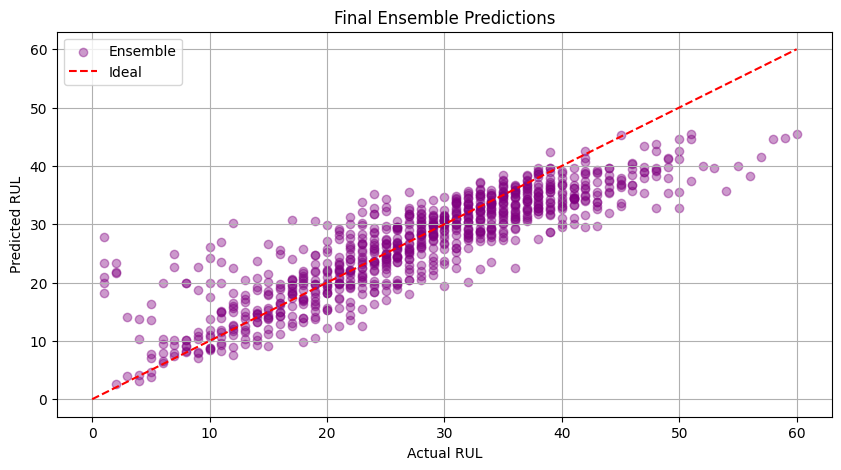

In [8]:
from sklearn.ensemble import RandomForestRegressor

# ==========================================
# 11. ENSEMBLING
# ==========================================
print("\n Attempting Ensemble (XGBoost + Random Forest)...")

# 1. Train Random Forest 
# use the same 'X_train_gmm' data
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=7,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_gmm, y_train)

# 2. Get Predictions from Both Models
pred_xgb = best_model_gmm.predict(X_test_gmm)  # optimized XGBoost
pred_rf = rf_model.predict(X_test_gmm)         # new Random Forest

# 3. Create "Blended" Prediction
# We trust XGBoost more (70%) because we optimized it, but let RF have a say (30%)
final_ensemble_preds = (0.7 * pred_xgb) + (0.3 * pred_rf)

# 4. Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
rmse_ensemble = np.sqrt(mean_squared_error(y_test, final_ensemble_preds))

print(f"\n📊 RESULTS OF ENSEMBLING:")
print(f"-----------------------------")
print(f"XGBoost Only RMSE: {rmse_xgb:.4f}")
print(f"RandomF Only RMSE: {rmse_rf:.4f}")
print(f"-----------------------------")
print(f"🔥 ENSEMBLE RMSE:  {rmse_ensemble:.4f}")

# Check if it helped
if rmse_ensemble < rmse_xgb:
    print("\n✅ SUCCESS: The combined model is better than the individual parts!")
    print(f"Improvement: {rmse_xgb - rmse_ensemble:.4f} months")
else:
    print("\n⚠️ RESULT: XGBoost was too strong. The Ensemble didn't beat it.")
    print("This is still a great finding: It proves your Grid Search found the global optimum!")

# Plot the difference
plt.figure(figsize=(10, 5))
plt.scatter(y_test, final_ensemble_preds, alpha=0.4, color='purple', label='Ensemble')
plt.plot([0, 60], [0, 60], 'r--', label='Ideal')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Final Ensemble Predictions')
plt.legend()
plt.grid(True)
plt.show()